## Table of Contents:
* [1 Case 3. Patient Drug Review](#case-3)
* [2 Background](#case-background)
* [3 Data](#loading-data)
* [4 Data Preprocessing](#data-preprocessing)
* [5 Models and Training](#models-trainning)
* [6 Conclusions](#cas-conclusion)

# Case 3. Patient Drug Review <a class="anchor" id="case-3"></a>
Team 14:<br>
* Awet Ghebreslassie
* Leevi Pelkonen
* Visa Soininen<br><br>
Last edited: 23.03.2020<br>
Neural Networks for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

# 2 Background  <a class="anchor" id="case-background"></a>

The aim of this Notebook is to predict the rating of a drug based on a review by the user. To achieve this model we use a SimpleRNN (Recurrent Neural Network). Hypothesis for this experiment is that this could be useful for medical industry to provide users with similar symptoms and/or health statuses to be prescribed the best available medication based on earlier reviews.

# 3 Data  <a class="anchor" id="loading-data"></a>

The dataset is from: [UCI ML Drug Review dataset](https://www.kaggle.com/jessicali9530/kuc-hackathon-winter-2018). Both the review and rating of the drug are user-provided and are affected by human decision making, as some people rate properties with a different scale.

Each sample contains a unique ID, the name of the drug reviewed, condition treated with the drug, review, rating, date and how many persons found the review useful.
Because we are interested in the connection between the review and the rating, we omit the other data. To generalize the output and minimize the small differences in human decision making the ratings are split in to three groups, negative, neutral and positive.

#  - Review
This column contains a short description provided by the user explaining their experience with the drug for each sample.

#  - Rating
This column contains a rating the user provided for the drug between 0-10

In [1]:
# imports
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Create dataframes train and test data

train_data = pd.read_csv("data/drugsComTrain_raw.csv")
test_data = pd.read_csv("data/drugsComTest_raw.csv")

train_data.head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
5,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,7-Mar-17,5
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,14-Mar-15,32
8,74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,9-Aug-16,11
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1


# 4 Data Preprocessing <a class="anchor" id="data-preprocessing"></a>

We will simplify the rating labels down to just three different classes: “negative” (rating < 5), “neutral” (rating 5 or 6) and “positive” (rating > 6) as per task suggention.

In [3]:
# Create three categories
# label = 2, when rating = > 6
# label = 1, when rating = 5 or 6
# label = 0, when rating = < 5
train_data['rating'] = np.where(train_data['rating'] > 6, 2, (np.where(train_data['rating'] < 5, 0, 1)))
test_data['rating'] = np.where(test_data['rating'] > 6, 2, (np.where(test_data['rating'] < 5, 0, 1)))

train_data.head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",2,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",2,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",1,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",2,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",2,27-Nov-16,37
5,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",0,28-Nov-15,43
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",0,7-Mar-17,5
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",2,14-Mar-15,32
8,74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",0,9-Aug-16,11
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",2,8-Dec-16,1


Since we are only intersted on review column and rating column we will extract only this data from our dataframes.

In [4]:
# extracting review values
train_samples = train_data['review'].values.tolist()
test_samples = test_data['review'].values.tolist()

# extracting rating/label values
train_labels = train_data['rating'].values
test_labels = test_data['rating'].values

One-hot encode categorical data

In [5]:
# Convert outputs to one-hot-coded categoricals

from tensorflow.keras.utils import to_categorical

train_labels_cat = to_categorical(train_labels)
test_labels_cat = to_categorical(test_labels)

print(train_labels_cat[:5])

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [6]:
# Tokenize the text

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(train_samples)

In [7]:
# Convert reviews to integer sequences

train_sequences = tokenizer.texts_to_sequences(train_samples)
test_sequences = tokenizer.texts_to_sequences(test_samples)
print(train_sequences[0])

[5, 38, 28, 35, 197, 1, 45, 5, 15, 848, 12, 2922, 99, 150, 2, 3806, 1551]


In [8]:
# Pad the reviews to have the same length

from tensorflow.keras import preprocessing

maxlen = 100

train_sequences = preprocessing.sequence.pad_sequences(train_sequences, maxlen = maxlen)
test_sequences = preprocessing.sequence.pad_sequences(test_sequences, maxlen = maxlen)
print(train_sequences[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    5
   38   28   35  197    1   45    5   15  848   12 2922   99  150    2
 3806 1551]


# 5 Models and training  <a class="anchor" id="models-trainning"></a>

First model attempt with only an Embedding-layer and Flattening-layer to outputting one of the three possible outputs.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, SimpleRNN

In [10]:
# Use word vectors of dimension 16, flatten and feed straight to output layer

model = Sequential()
model.add(Embedding(5000, 16, input_length = maxlen))
model.add(Flatten())
model.add(Dense(3, activation = 'softmax'))

In [11]:
# Compile the model
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])

In [12]:
# Train the model
history = model.fit(train_sequences, train_labels_cat, epochs = 4, batch_size=32, validation_split = 0.2, verbose=0)

Plot the training progress, first the ploting the training and validation loss.

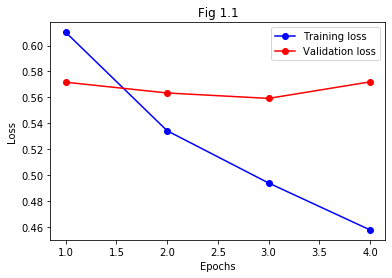

In [13]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, 'bo-', label='Training loss')
plt.plot(epochs, val_loss_values, 'ro-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Fig 1.1')
plt.show()


Ploting training and validation accuracy.

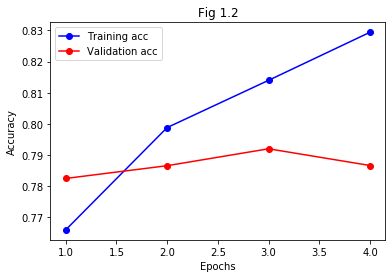

In [14]:
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo-', label='Training acc')
plt.plot(epochs, val_acc_values, 'ro-', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Fig 1.2')
plt.show()

In [15]:
prediction = model.predict_classes(test_sequences)

In [16]:
confusion_matrix(test_labels, prediction).T

array([[10348,  1812,  3405],
       [  359,   608,   622],
       [ 2790,  2409, 31413]], dtype=int64)

In [17]:
print(classification_report(test_labels, prediction))

              precision    recall  f1-score   support

           0       0.66      0.77      0.71     13497
           1       0.38      0.13      0.19      4829
           2       0.86      0.89      0.87     35440

    accuracy                           0.79     53766
   macro avg       0.64      0.59      0.59     53766
weighted avg       0.77      0.79      0.77     53766



In [18]:
cohen_kappa_score(test_labels ,prediction)

0.5545100881506025

### SimpleRNN model

Second model attempt with a RNN-layer between the Embedding-layer and the output-layer

In [19]:
model = Sequential()
model.add(Embedding(5000, 16))
model.add(SimpleRNN(16))
model.add(Dense(3, activation = 'softmax'))

In [20]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])

In [21]:
history = model.fit(train_sequences, train_labels_cat, epochs = 5, batch_size=320, validation_split=0.2, verbose=0)

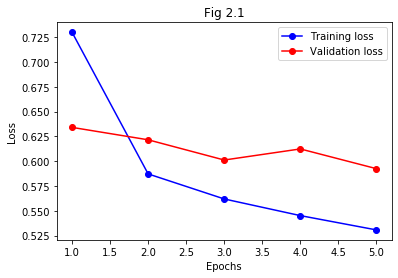

In [22]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, 'bo-', label='Training loss')
plt.plot(epochs, val_loss_values, 'ro-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Fig 2.1')
plt.show()

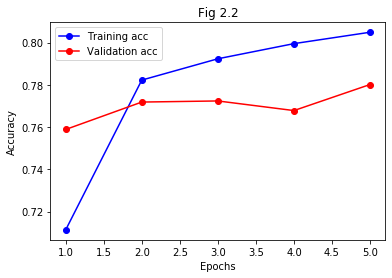

In [23]:
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo-', label='Training acc')
plt.plot(epochs, val_acc_values, 'ro-', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Fig 2.2')
plt.show()

In [24]:
prediction = model.predict_classes(test_sequences)

In [25]:
confusion_matrix(test_labels, prediction).T

array([[ 8152,  1115,  1520],
       [  513,   241,   329],
       [ 4832,  3473, 33591]], dtype=int64)

In [26]:
print(classification_report(test_labels, prediction))

              precision    recall  f1-score   support

           0       0.76      0.60      0.67     13497
           1       0.22      0.05      0.08      4829
           2       0.80      0.95      0.87     35440

    accuracy                           0.78     53766
   macro avg       0.59      0.53      0.54     53766
weighted avg       0.74      0.78      0.75     53766



In [27]:
cohen_kappa_score(test_labels,prediction)

0.49530920664975964

# 7 Conclusions  <a class="anchor" id="cas-conclusion"></a>

Given the circumstances of the rating and the review both being human-generated, we feel that the results are good.

As shown in figure 2.2, the training and validation accuracy steadily climbed during the first five epochs of training, leading to a validation accuracy of 78%. This portrays a good trend of the model outputting the tone of the review correctly on the majority of the samples.